In [221]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

CARGA DATOS. Cortesia de Thomas Andrade

In [222]:
def matrixCreator(raw, pixelsX, pixelsY):
    matrix = []
    for i in range(0, len(raw), pixelsX*pixelsY):
        blank = np.zeros((pixelsX, pixelsY))
        for j in range(0, pixelsX):
            for k in range(0, pixelsY):
                blank[j, k] = raw[k + pixelsX*j + i]
        matrix.append(blank) 
    return matrix

def dataCreator(filename, pixelsX, pixelsY):
    raw_array = np.fromfile(filename, dtype = "float32")
    matrix = matrixCreator(raw_array, pixelsX, pixelsY)
    return matrix

def imageCreator(data, COLValue):
    image = []
    mean = 0
    for i in range(0, COLValue + 1):
        mean += data[i]
    mean = mean/(COLValue + 1)
    image.append(mean)  
    return image[0]

In [223]:
directory = "C:\\Users\\Thomas\\Downloads\\Frame_1_d0.46m_a10um_p110um_step-4.2_dith23.25_th1_10000eV_1.raw" # String con el directorio donde se encuentra el .raw.
COL = 0 # Cambiar por el tipo de adquisición.
pixelsX = 256 
pixelsY = 256

In [224]:
sample = dataCreator(directory, pixelsX, pixelsY)
image = imageCreator(sample, COL)

Imagen original

Text(0, 0.5, 'Pixels in the Y-axis')

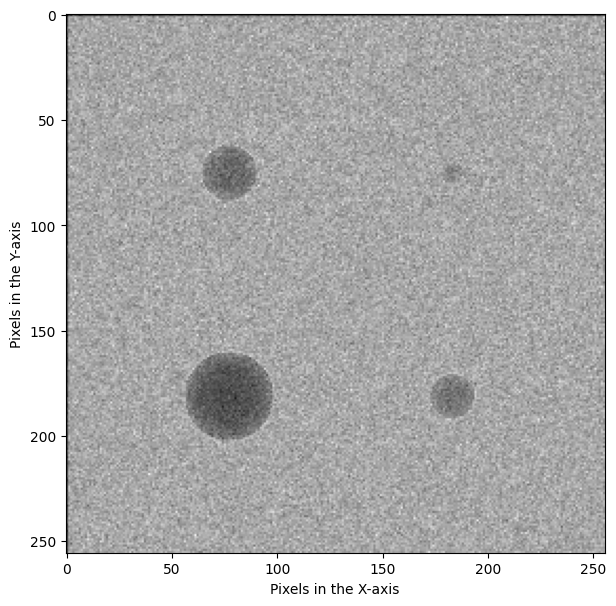

In [225]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image, cmap = "grey")
ax.set_xlabel("Pixels in the X-axis")
ax.set_ylabel("Pixels in the Y-axis")

Imagen Normalizada

Text(0, 0.5, 'Pixels in the Y-axis')

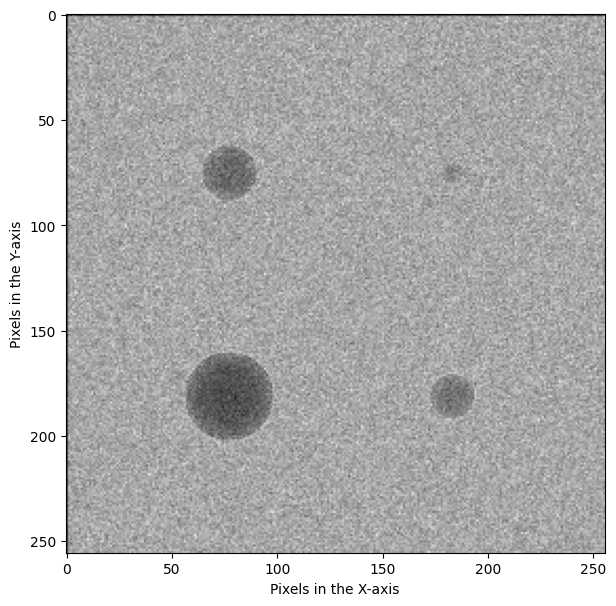

In [226]:
normalizada = (image - np.min(image)) / (np.max(image) - np.min(image))

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(normalizada, cmap="grey")
ax.set_xlabel("Pixels in the X-axis")
ax.set_ylabel("Pixels in the Y-axis")


Imagen normalizada columnas pares

Text(0, 0.5, 'Pixels in the Y-axis')

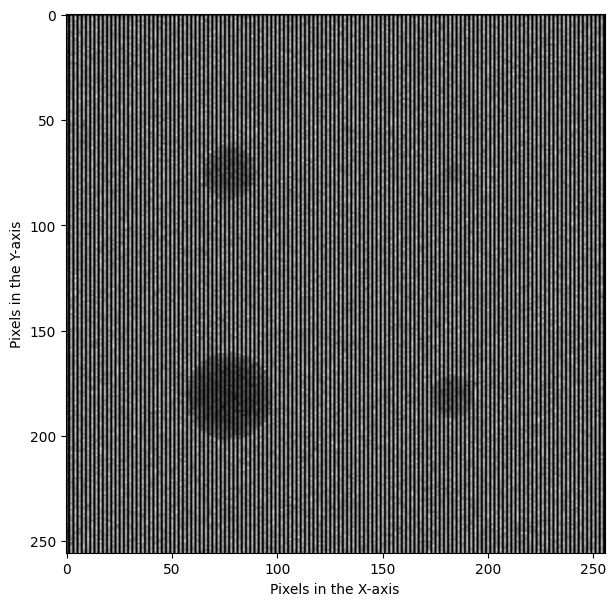

In [ ]:
normalizada_pares = normalizada.copy()
normalizada_pares[:, 1::2] = 0  # Pone en cero las columnas impares

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(normalizada_pares, cmap="grey")
ax.set_xlabel("Pixels in the X-axis")
ax.set_ylabel("Pixels in the Y-axis")


Imagen Normalizada Columnas impares

Text(0, 0.5, 'Pixels in the Y-axis')

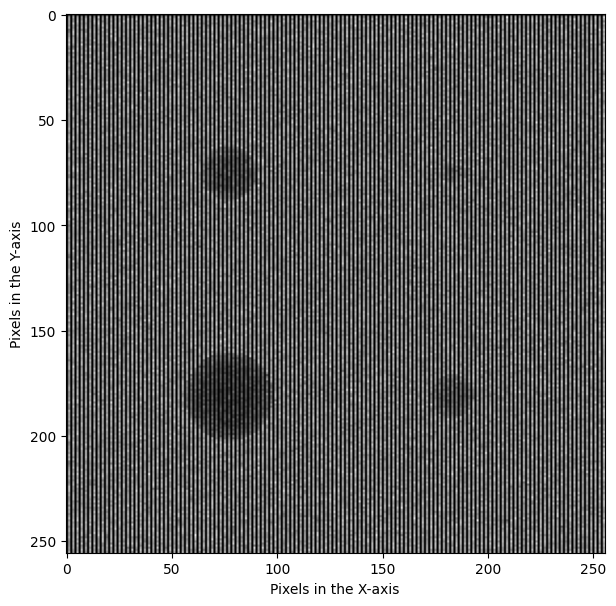

In [228]:
# ...existing code...
normalizada_impares = normalizada.copy()
normalizada_impares[:, ::2] = 0  # Pone en cero las columnas pares

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(normalizada_impares, cmap="grey")
ax.set_xlabel("Pixels in the X-axis")
ax.set_ylabel("Pixels in the Y-axis")
# ...existing code...

HISTOGRAMAS PIXELES

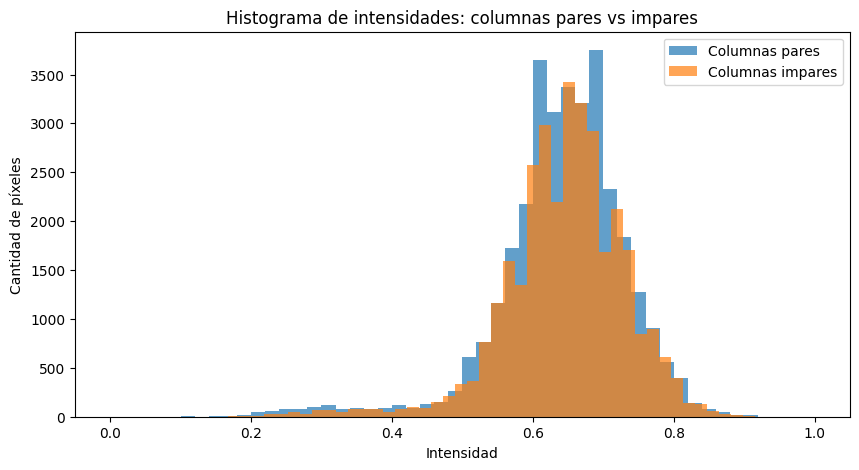

In [229]:
# ...existing code...
# Extraer intensidades de columnas pares e impares
intensidades_pares = normalizada[:, ::2].flatten()    # columnas pares
intensidades_impares = normalizada[:, 1::2].flatten() # columnas impares

plt.figure(figsize=(10,5))
plt.hist(intensidades_pares, bins=50, alpha=0.7, label="Columnas pares")
plt.hist(intensidades_impares, bins=50, alpha=0.7, label="Columnas impares")
plt.xlabel("Intensidad")
plt.ylabel("Cantidad de píxeles")
plt.title("Histograma de intensidades: columnas pares vs impares")
plt.legend()
plt.show()
# ...existing code...

Imagen Normalizada filas Pares

Text(0, 0.5, 'Pixels in the Y-axis')

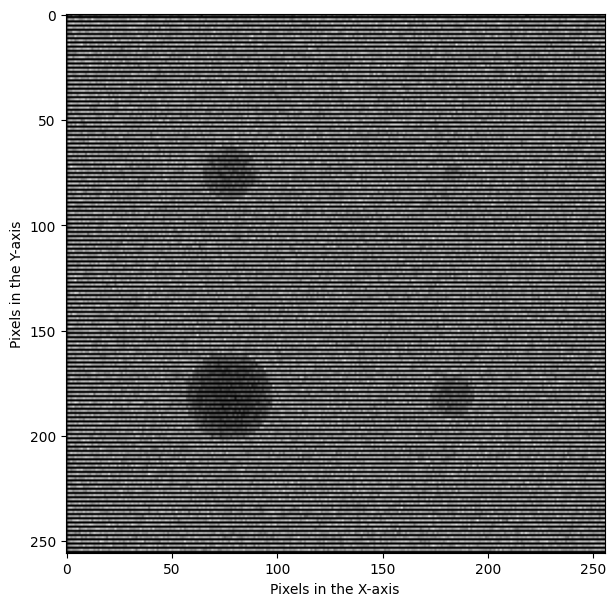

In [230]:

normalizada_pares_y = normalizada.copy()
normalizada_pares_y[1::2, :] = 0  # Pone en cero las filas impares (corte horizontal)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(normalizada_pares_y, cmap="grey")
ax.set_xlabel("Pixels in the X-axis")
ax.set_ylabel("Pixels in the Y-axis")


Imagen normalizada filas impares

Text(0, 0.5, 'Pixels in the Y-axis')

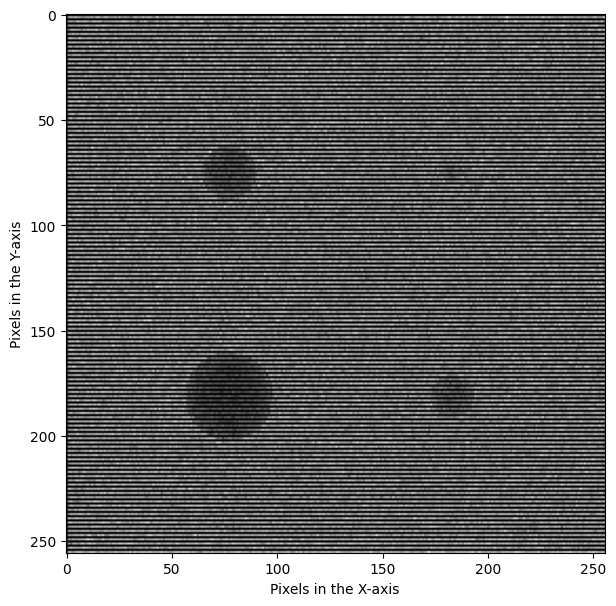

In [231]:

normalizada_impares_y = normalizada.copy()
normalizada_impares_y[::2, :] = 0  # Pone en cero las filas pares (solo quedan las impares)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(normalizada_impares_y, cmap="grey")
ax.set_xlabel("Pixels in the X-axis")
ax.set_ylabel("Pixels in the Y-axis")


Imagen normalizada Pixel Pares

Text(0, 0.5, 'Pixels in the Y-axis')

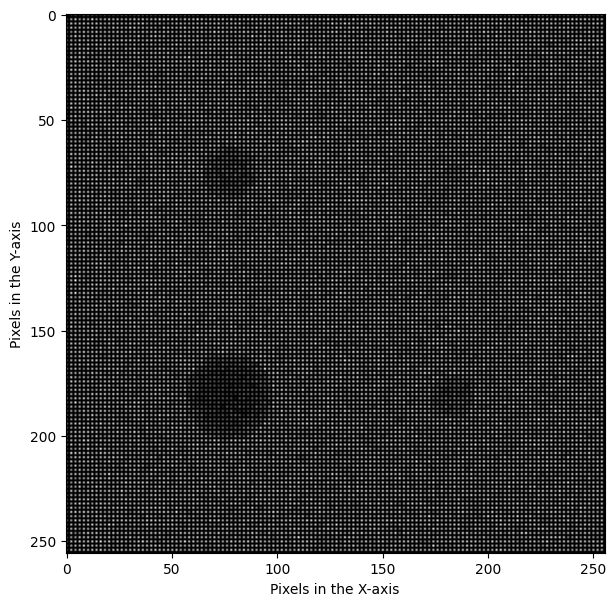

In [232]:
# ...existing code...
normalizada_pares_xy = normalizada.copy()
normalizada_pares_xy[1::2, :] = 0  # Pone en cero las filas impares (y)
normalizada_pares_xy[:, 1::2] = 0  # Pone en cero las columnas impares (x)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(normalizada_pares_xy, cmap="grey")
ax.set_xlabel("Pixels in the X-axis")
ax.set_ylabel("Pixels in the Y-axis")
# ...existing code...

-------------------Analisis-------------------

Cortes Transversales en linea horizontal en pixel Y 170 (Solo agarra la esfera grande)

Text(0.5, 1.0, 'Intensidad por corte longitudinal')

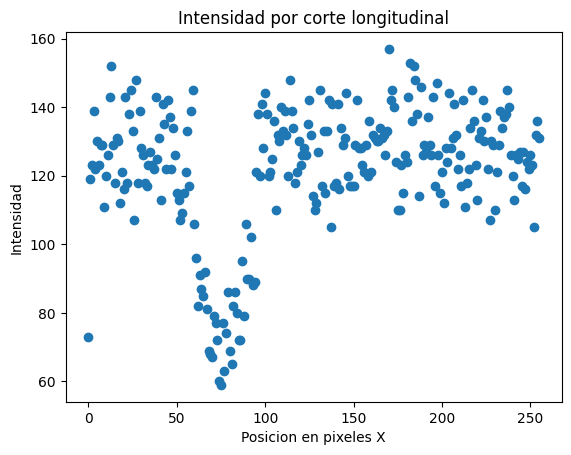

In [233]:
copia = image.copy()
corte = np.linspace(0, pixelsX-1, pixelsX)
I_corte = copia[170, :]
plt.scatter(corte,I_corte)
plt.xlabel("Posicion en pixeles X")
plt.ylabel("Intensidad")
plt.title("Intensidad por corte longitudinal")

Limpieza por fourier

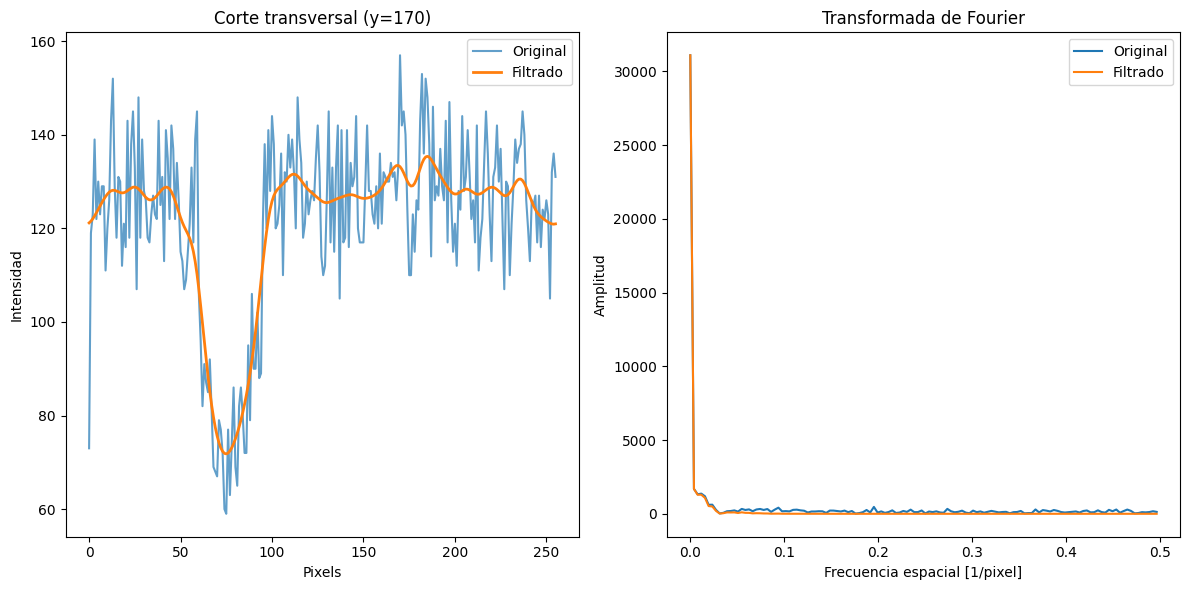

In [234]:
copia = image.copy()

# Corte transversal en y=170
corte = np.linspace(0, pixelsX-1, pixelsX)
I_corte = copia[170, :]

# FFT del corte
fourier_I = np.fft.fft(I_corte)
frecuencias = np.fft.fftfreq(len(I_corte), d=1)  # paso espacial=1 pixel

# Filtro pasabajas: mantenemos solo bajas frecuencias
a=20
filtro = np.exp(-(frecuencias*a)**2) #si a muy grande es una linea recta, si muy pequeno mucho ruido
espectro_filtrado = fourier_I * filtro
filtro_2 = np.where(np.abs(frecuencias) < 0.001, 1, 0) #si a muy grande  mucho ruido, si a muy pequena se aplana
x2 = fourier_I * filtro_2
fourier_filtrado = fourier_I * filtro

# Reconstrucción con IFFT
I_filtrado = np.fft.ifft(fourier_filtrado).real

# Gráficas
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(corte, I_corte, label="Original", alpha=0.7)
plt.plot(corte, I_filtrado, label="Filtrado", linewidth=2)
plt.xlabel("Pixels")
plt.ylabel("Intensidad")
plt.title("Corte transversal (y=170)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(frecuencias[:len(frecuencias)//2], np.abs(fourier_I[:len(fourier_I)//2]), label="Original")
plt.plot(frecuencias[:len(frecuencias)//2], np.abs(fourier_filtrado[:len(fourier_filtrado)//2]), label="Filtrado")
plt.xlabel("Frecuencia espacial [1/pixel]")
plt.ylabel("Amplitud")
plt.title("Transformada de Fourier")
plt.legend()

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Corte transversal (y=170)')

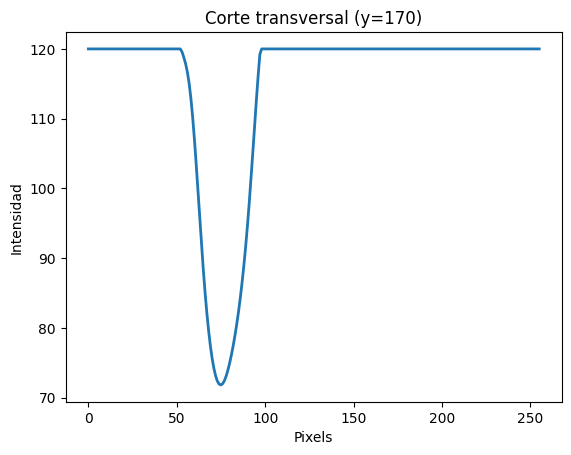

In [235]:
for pixel in range(0,len(corte)):
    if I_filtrado[pixel]>120:
        I_filtrado[pixel]=120
plt.plot(corte, I_filtrado, label="Filtrado", linewidth=2)
plt.xlabel("Pixels")
plt.ylabel("Intensidad")
plt.title("Corte transversal (y=170)")


calculamos derivadas

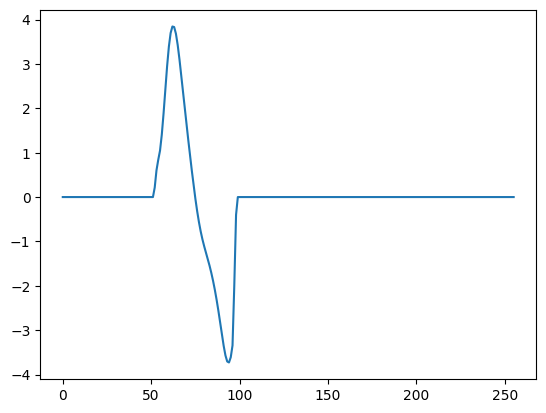

In [236]:

derivada = -np.gradient(I_filtrado,corte)
plt.plot(corte,derivada)

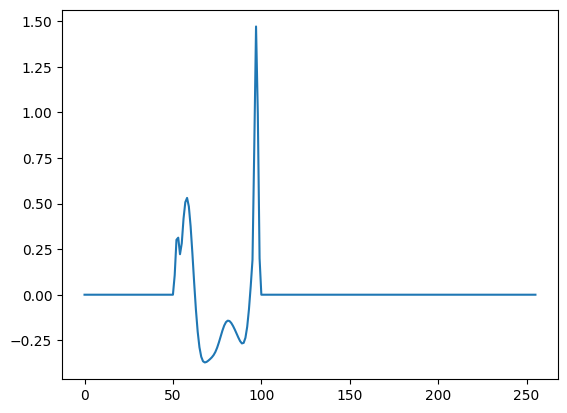

In [237]:
derivada2 = np.gradient(derivada,corte)
plt.plot(corte,derivada2)

Para toda la imagen

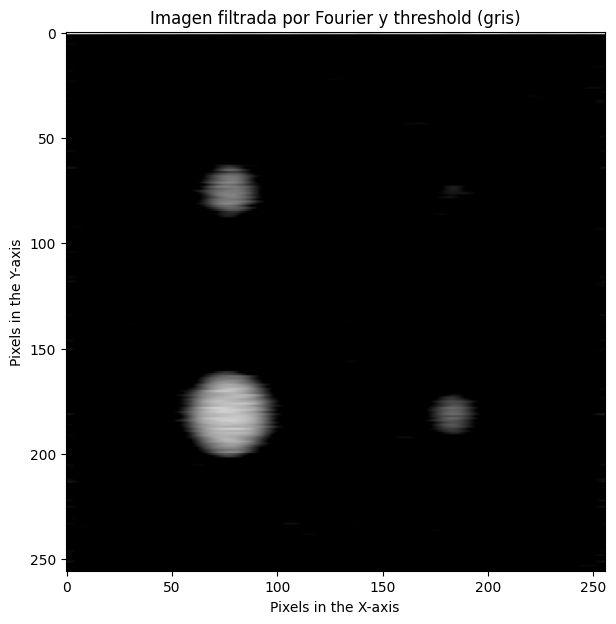

In [238]:

# Parámetros del filtro
a = 20
threshold = 120  # Cambia este valor según tu necesidad

# Crear imagen filtrada
imagen_filtrada = np.zeros_like(image)

gris = 120 # Valor de gris (ajusta según el rango de tu imagen, por ejemplo 0-255)

for y in range(image.shape[0]):
    I_corte = image[y, :]
    fourier_I = np.fft.fft(I_corte)
    frecuencias = np.fft.fftfreq(len(I_corte), d=1)
    filtro = np.exp(-(frecuencias * a) ** 2)
    fourier_filtrado = fourier_I * filtro
    I_filtrado = np.fft.ifft(fourier_filtrado).real

    # Filtro de threshold: valores mayores al threshold se igualan al gris
    I_filtrado[I_filtrado > threshold] = gris

    imagen_filtrada[y, :] = I_filtrado

# Mostrar la imagen filtrada
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(-imagen_filtrada, cmap="grey") #el - es para que salga el negativo
ax.set_xlabel("Pixels in the X-axis")
ax.set_ylabel("Pixels in the Y-axis")
plt.title("Imagen filtrada por Fourier y threshold (gris)")
plt.show()


Comprobando en un corte

Text(0.5, 1.0, 'Intensidad por corte longitudinal')

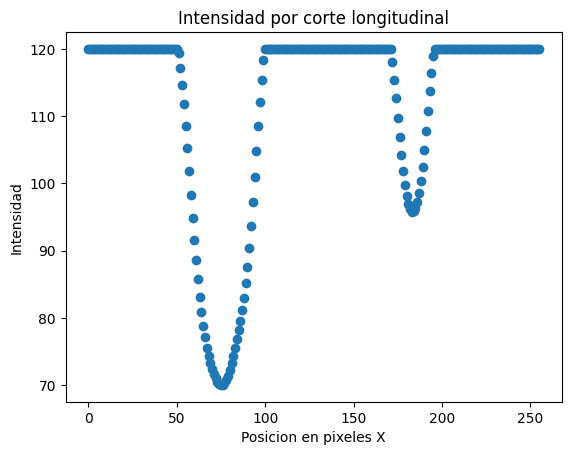

In [239]:
copia = imagen_filtrada.copy()
corte = np.linspace(0, pixelsX-1, pixelsX)
I_corte = copia[180, :]
plt.scatter(corte,I_corte)
plt.xlabel("Posicion en pixeles X")
plt.ylabel("Intensidad")
plt.title("Intensidad por corte longitudinal")

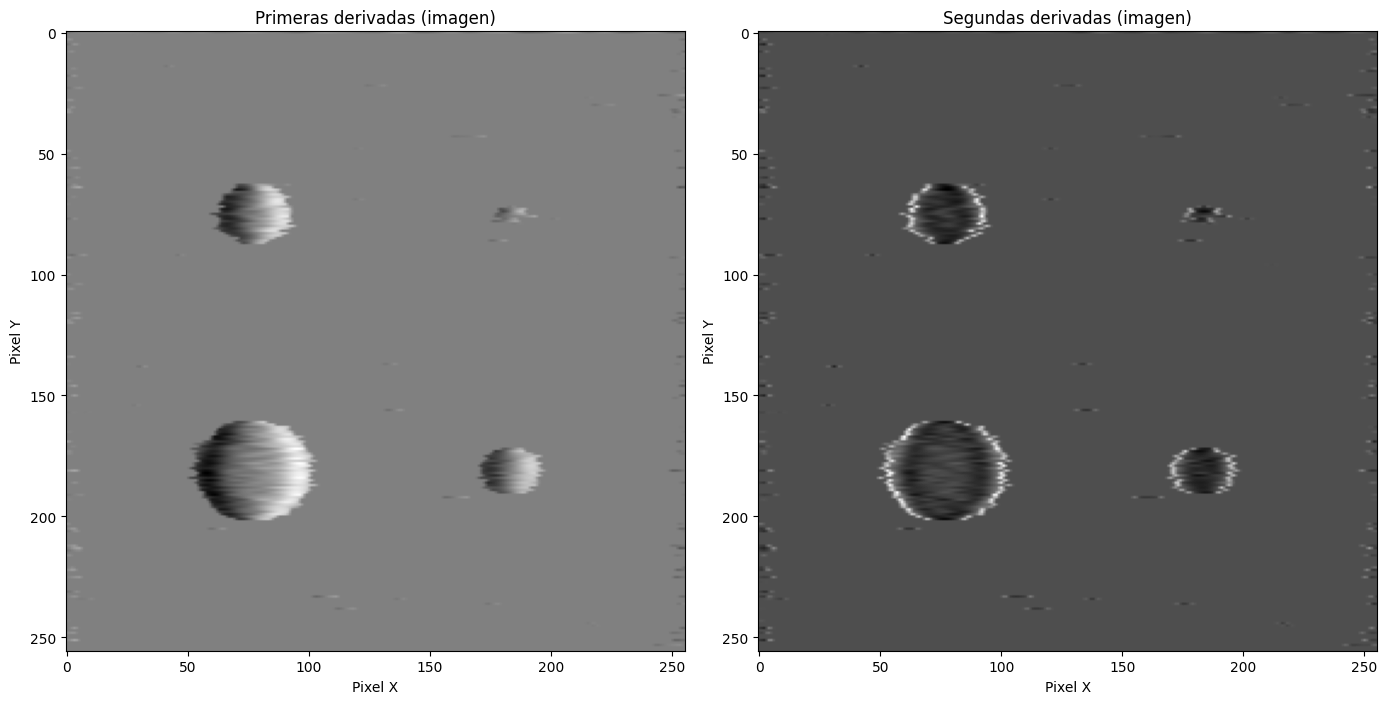

In [240]:
# Crear matrices para primeras y segundas derivadas
primeras_derivadas = np.zeros_like(imagen_filtrada)
segundas_derivadas = np.zeros_like(imagen_filtrada)

for y in range(imagen_filtrada.shape[0]):
    I_corte = imagen_filtrada[y, :]
    corte = np.arange(imagen_filtrada.shape[1])
    primeras_derivadas[y, :] = np.gradient(I_corte, corte)
    segundas_derivadas[y, :] = -np.gradient(primeras_derivadas[y, :], corte)

# Graficar como imágenes
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(primeras_derivadas, cmap="grey")
axs[0].set_title("Primeras derivadas (imagen)")
axs[0].set_xlabel("Pixel X")
axs[0].set_ylabel("Pixel Y")
axs[1].imshow(segundas_derivadas, cmap="grey")
axs[1].set_title("Segundas derivadas (imagen)")
axs[1].set_xlabel("Pixel X")
axs[1].set_ylabel("Pixel Y")
plt.tight_layout()
plt.show()


--------------- LIBRERIAS --------------- 

Recuperacion fase

In [241]:
# import napari
# from skimage import filters

# viewer = napari.Viewer()
# viewer.add_image(image, name="original")
# viewer.add_image(filters.sobel(image), name="fase (Sobel)")
# napari.run()
